In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gp import *
from data_loader import data_loader

In [10]:
filename = 'trajectory.pkl'
compute_reduction = 100
n_training_samples = 1

d_loader = data_loader(filename, compute_reduction, n_training_samples)               


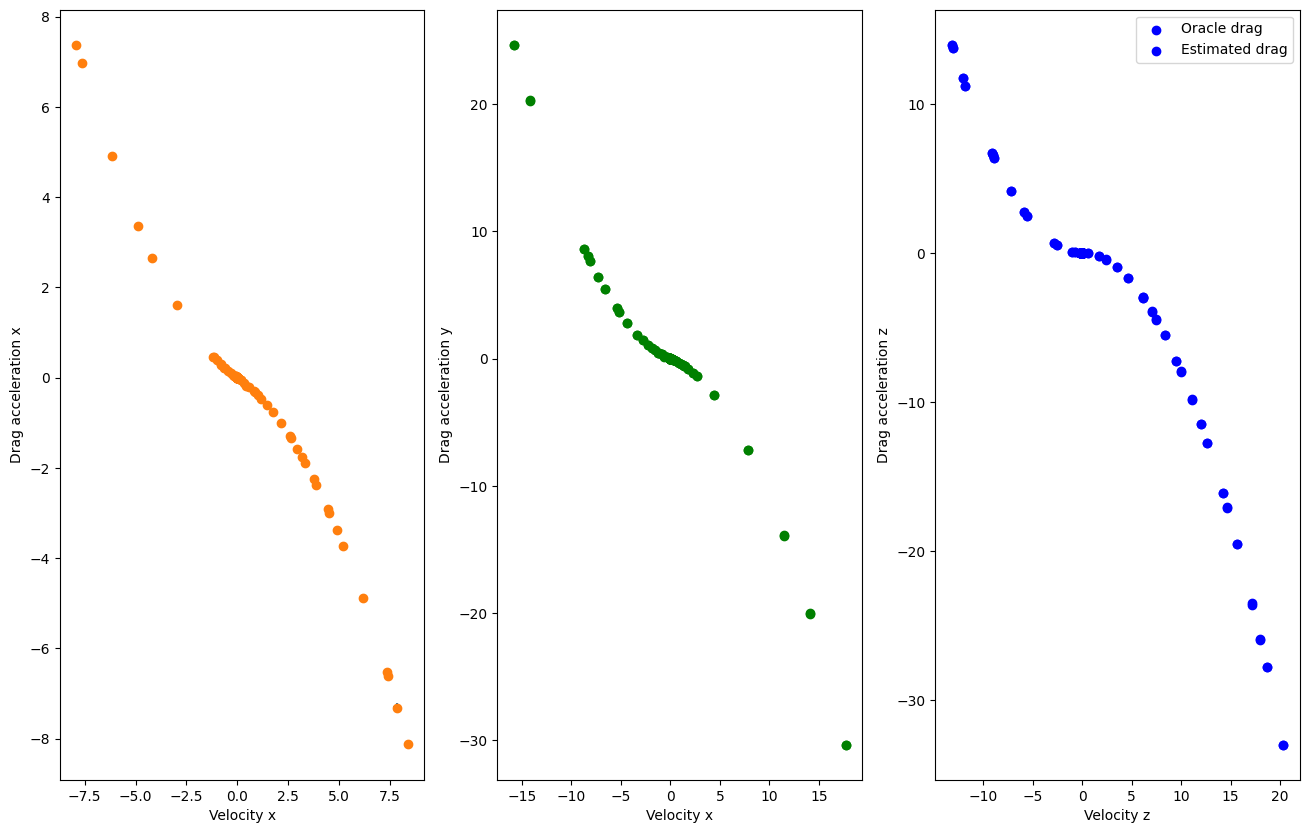

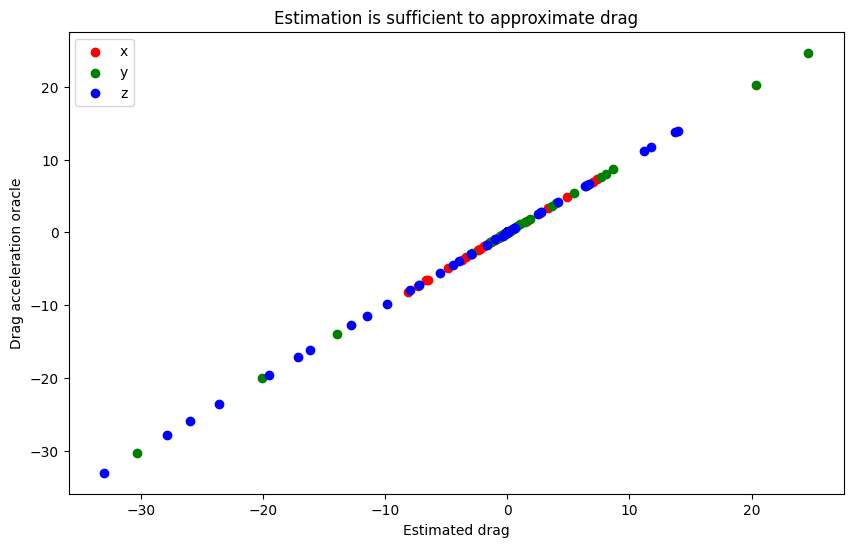

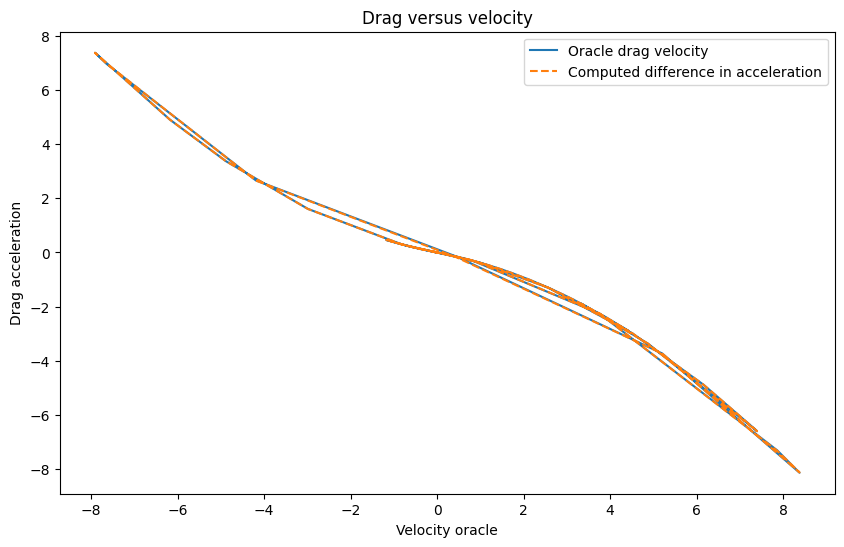

In [19]:
v = d_loader.v
a_validation = d_loader.a_validation

plt.figure(figsize=(16, 10), dpi=100)
plt.subplot(131)
plt.scatter(v[:,0], a_validation[:,0], marker='+')
plt.scatter(v[:,0], d_loader.y[:,0])
plt.xlabel('Velocity x')
plt.ylabel('Drag acceleration x')
plt.subplot(132)
plt.scatter(v[:,1], a_validation[:,1], c='g')
plt.scatter(v[:,1], d_loader.y[:,1], c='g')
plt.xlabel('Velocity x')
plt.ylabel('Drag acceleration y')
plt.subplot(133)
plt.scatter(v[:,2], a_validation[:,2], c='b')
plt.scatter(v[:,2], d_loader.y[:,2], c='b')
plt.xlabel('Velocity z')
plt.ylabel('Drag acceleration z')
plt.legend(('Oracle drag', 'Estimated drag'))



plt.figure(figsize=(10, 6), dpi=100)
plt.scatter(d_loader.y[:,0], a_validation[:,0], c='r')
plt.scatter(d_loader.y[:,1], a_validation[:,1], c='g')
plt.scatter(d_loader.y[:,2], a_validation[:,2], c='b')
plt.xlabel('Estimated drag')
plt.ylabel('Drag acceleration oracle')
plt.title('Estimation is sufficient to approximate drag')
plt.legend(('x', 'y', 'z'))


plt.figure(figsize=(10, 6), dpi=100)

plt.plot(v[:,0], a_validation[:,0], '-')
plt.plot(v[:,0], d_loader.y[:,0], '--')
#plt.plot(z_train[:,7], y_x_train, '+')
plt.xlabel('Velocity oracle')
plt.ylabel('Drag acceleration')
plt.title('Drag versus velocity')
plt.legend(('Oracle drag velocity', 'Computed difference in acceleration'))

In [ ]:
print(d_loader.get_z(training=False))
print(d_loader.get_y(training=False))
d_loader.shuffle()
print(d_loader.get_z(training=False))
print(d_loader.get_y(training=False))


z = d_loader.z
y = d_loader.y

z_train = d_loader.get_z(training=True)
y_train = d_loader.get_y(training=True)


y_x_train = d_loader.get_y_x(training=True)
y_x = d_loader.get_y_x(training=False)

In [ ]:

def nll(z_train, y_train, kernel):
    def nll_stable(theta):

        # Numerically more stable implementation of Eq. (11) as described
        # in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, Section
        # 2.2, Algorithm 2.1.
        k = kernel(L=np.diag(theta[:-2]), sigma_f=theta[-2])
    
        K = calculate_covariance_matrix(z_train, z_train, k) + (theta[-1]+1e-7)*np.identity(z_train.shape[0])
        L = cholesky(K)

        S1 = solve_triangular(L, y_train, lower=True)
        S2 = solve_triangular(L.T, S1, lower=False)

        return (np.sum(np.log(np.diagonal(L))) + \
               0.5 * y_train.T.dot(S2) + \
               0.5 * z_train.shape[0] * np.log(2*np.pi)).flatten()
    
    
    return nll_stable

In [ ]:
theta0 = [1,1,1] # Kernel variables
z_velx = z_train[:,7].reshape(-1,1) # just x velocity

kernel = RBF(L=np.eye(z_velx.shape[1])*theta0[0], sigma_f=theta0[1])
model = GPR(z_velx, y_x, noise=theta0[2], covariance_function=kernel)

x_query = np.arange(-10,10,0.1).reshape(-1,1)
mean, std = model.predict(x_query, std=True)


plt.figure(figsize=(10,6), dpi=100)
plt.plot(x_query, mean)
plt.plot(z[:,7], y[:,0], '+')
plt.plot(z_train[:,7], y_x[:,0], 'x')
plt.fill_between(x_query.reshape(-1), mean.reshape(-1) - std, mean.reshape(-1) + std,
                 color='gray', alpha=0.2)

plt.xlabel('Velocity in x [ms-1]')
plt.ylabel('Acceleration error in x [ms-2]')
plt.title('GP fit')
plt.legend(('GP fit', 'Measured samples', 'Training samples'))

In [ ]:
from scipy.optimize import minimize

neg_log_fcn = nll(z_velx, y_x, RBF)

bnds = ((0, None), (0, None), (0, None))
sol_min = minimize(neg_log_fcn, x0=theta0, method='L-BFGS-B', bounds=bnds)
theta_star = sol_min.x

In [ ]:
z_velx = z_train[:,7].reshape(-1,1) # just x velocity

kernel = RBF(L=np.eye(z_velx.shape[1])*theta_star[0], sigma_f=theta_star[1])
model = GPR(z_velx, y_x, noise=theta_star[2], covariance_function=kernel)

x_query = np.arange(-10,10,0.1).reshape(-1,1)
mean, std = model.predict(x_query, std=True)

plt.figure(figsize=(10,6), dpi=100)
plt.plot(x_query, mean)
plt.plot(z[:,7], y[:,0], '+')
plt.plot(z_train[:,7], y_x[:,0], 'x')
plt.fill_between(x_query.reshape(-1), mean.reshape(-1) - std, mean.reshape(-1) + std,
                 color='gray', alpha=0.2)

plt.xlabel('Velocity in x [ms-1]')
plt.ylabel('Acceleration error in x [ms-2]')
plt.title('GP fit')
plt.legend(('GP fit', 'Measured samples', 'Training samples'))